In [1]:
# Required libraries :
# tensorflow
# yfinance
# matplotlib
# pandas
# numpy

Install all the above mentioned libraries using <b>'pip'</b>. <br>
For example to install <b>yfinance</b>, run : `pip install yfinance`    

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

### Deciding two things:
1. the <b>dates</b> over which we want to collect the data
2. the <b>stock symbol</b> for which we want to train the model

In [3]:
# we chose the 'ITC' stock over the NSE market over a period of 10 years
start = '2012-01-01'
end = '2022-12-21'
stock = 'ITC.NS' 

In [4]:
#downloading the data
data = yf.download(stock,start,end)

[*********************100%%**********************]  1 of 1 completed


### EDA

In [5]:
# create a new pandas dataframe using the data received from yfinance
prices = pd.DataFrame(data)
prices.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-31,180.000000,180.333328,177.533340,178.433334,134.856400,7843771
2016-12-28,232.699997,236.399994,232.699997,235.449997,188.631775,14166131
2014-12-05,255.333328,261.333344,255.100006,260.899994,203.780807,16281654
2012-11-21,187.033340,191.500000,185.733337,190.733337,144.152481,8277627
2013-04-03,204.633331,206.266663,202.899994,205.066666,154.985336,7238014
2013-07-19,245.666672,247.933334,243.466660,246.033340,188.743927,8103916
2016-12-07,231.500000,231.500000,226.500000,227.199997,182.022278,8107530
2022-03-02,214.399994,216.600006,212.449997,215.300003,205.831284,19295994
2013-09-10,213.333328,225.600006,212.666672,223.933334,171.789978,18161731


In [6]:
#checking null values
prices.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
prices.shape

(2705, 6)

In [8]:
#add a new row to indicate the indeces
prices.reset_index(inplace=True)

In [9]:
prices.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1447,2017-11-17,256.500000,259.000000,256.000000,258.000000,209.820160,9998498
1894,2019-09-16,239.500000,240.850006,238.300003,239.399994,202.212296,7084644
1166,2016-09-29,248.100006,249.300003,241.000000,245.699997,196.843628,17433461
1547,2018-04-16,260.500000,264.899994,260.000000,264.450012,215.065704,5212182
944,2015-11-03,224.533340,225.933334,221.866669,223.233337,177.848862,3911080
1574,2018-05-24,274.000000,276.799988,271.750000,274.850006,223.523514,6282351
874,2015-07-22,208.066666,211.966660,207.133331,209.666672,167.040375,7761358
1216,2016-12-14,236.000000,236.500000,232.000000,233.149994,186.789154,6313305
282,2013-02-21,199.666672,200.333328,196.500000,197.733337,149.442963,15478765
1285,2017-03-24,278.850006,283.000000,278.750000,281.000000,225.124405,7123953


In [10]:
prices.shape

(2705, 7)

as we can see, a new column has been added and the <b>shape[1]</b> increased from *6* to *7*

### Prediction strategy
Our model will be trained to predict the price of a particular stock using the <b>moving average</b> of the same for the past *100* days.<br>
This implies that the fluctuations in the last *100* days of the price will be studied and the price for the *101*st day will be predicted using that.

### Plotting the moving averages

In [11]:
#calculating the moving average using rolling() function and finding the mean over a period of 100 days (window size =100)
ma_100=prices.Close.rolling(100).mean()

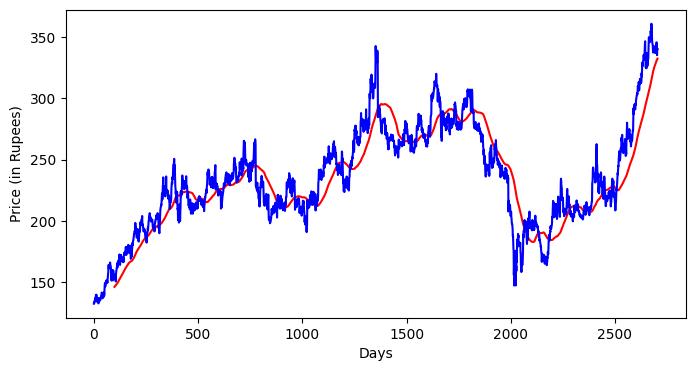

In [12]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'r')
plt.plot(prices['Close'],'b')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

In [13]:
#Calculating the moving average of 200 days
ma_200= prices['Close'].rolling(200).mean()

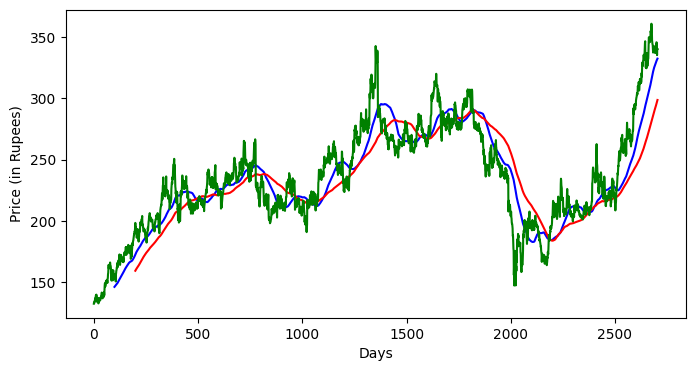

In [14]:
plt.figure(figsize=(8,4))
plt.plot(ma_100,'b')
plt.plot(ma_200,'r')
plt.plot(prices['Close'],'g')
plt.ylabel("Price (in Rupees)")
plt.xlabel("Days")
plt.show()

### Splitting the dataset into training and testing

In [15]:
#adding the first 80% of the data values into training set and the rest 20% into test set
data_train = prices['Close'][0:int(len(prices)*0.80)]
data_test = prices['Close'][int(len(prices)*0.80):len(prices)]

In [16]:
#viewing the first 5 values of the 
data_train.head()

0    132.433334
1    133.566666
2    133.033340
3    133.199997
4    134.733337
Name: Close, dtype: float64

In [17]:
data_test.head()

2164    165.699997
2165    168.250000
2166    167.449997
2167    167.649994
2168    168.550003
Name: Close, dtype: float64

In [18]:
print(data_train.shape,data_test.shape)

(2164,) (541,)


In [19]:
#scaling down the training and test set values to lie b/w 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

In [20]:
#reshaping the training dataset to form a 2d array
data_train = np.array(data_train)
data_train=data_train.reshape(-1,1)
data_train

array([[132.43333435],
       [133.56666565],
       [133.03334045],
       ...,
       [170.1499939 ],
       [167.80000305],
       [165.05000305]])

In [21]:
data_train_scale = scaler.fit_transform(data_train)

In [22]:
data_train_scale

array([[0.        ],
       [0.0053951 ],
       [0.00285627],
       ...,
       [0.17954614],
       [0.16835926],
       [0.15526818]])

In [23]:
data_test = np.array(data_test)
data_test = data_test.reshape(-1,1)
data_test[:10]

array([[165.69999695],
       [168.25      ],
       [167.44999695],
       [167.6499939 ],
       [168.55000305],
       [170.75      ],
       [168.55000305],
       [167.19999695],
       [165.5       ],
       [163.8500061 ]])

In [24]:
data_test_scale = scaler.fit_transform(data_test)

In [25]:
data_test_scale[10:20]

array([[0.00711198],
       [0.014732  ],
       [0.03175006],
       [0.03022604],
       [0.05537208],
       [0.05130805],
       [0.04546607],
       [0.07366015],
       [0.1089662 ],
       [0.12268221]])

we take the data from past 100 days each time to predict the price of stock for the 101th day

In [36]:
x=[]
y=[]
for i in range(100,data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [27]:
#converting the input features into numpy arrays
x= np.array(x)
y= np.array(y)

### Model Creation

A <b>Sequential</b> object can be used to group several layers of a neural network and group them together instead of individually creating every single layer and implementing it in the code.

In [28]:
#Creating a Sequential object
model = Sequential()
model.add(LSTM(units=50, activation='relu',return_sequences= True, input_shape=((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu',return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu',return_sequences= True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(x,y,epochs=50,batch_size=32, verbose=1)

Epoch 1/50
65/65 [==============================] - 12s 137ms/step - loss: 0.0496
Epoch 2/50
65/65 [==============================] - 9s 139ms/step - loss: 0.0120
Epoch 3/50
65/65 [==============================] - 9s 137ms/step - loss: 0.0111
Epoch 4/50
65/65 [==============================] - 9s 139ms/step - loss: 0.0096
Epoch 5/50
65/65 [==============================] - 9s 137ms/step - loss: 0.0090
Epoch 6/50
65/65 [==============================] - 9s 137ms/step - loss: 0.0084
Epoch 7/50
65/65 [==============================] - 9s 137ms/step - loss: 0.0078
Epoch 8/50
65/65 [==============================] - 9s 138ms/step - loss: 0.0078
Epoch 9/50
65/65 [==============================] - 9s 138ms/step - loss: 0.0074
Epoch 10/50
65/65 [==============================] - 9s 140ms/step - loss: 0.0070
Epoch 11/50
65/65 [==============================] - 9s 138ms/step - loss: 0.0071
Epoch 12/50
65/65 [==============================] - 9s 138ms/step - loss: 0.0061
Epoch 13/50
65/65 [=====

In [31]:
#model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

### Evaluation of model

We predict the closing price of a stock for nth day using the data for the last n-100 days. So we need to add the last *100* rows from the training dataset into the test dataset to evaluate the values after that and so on and so forth

In [32]:
#converting np array into pd dataframe and finding the last 100 rows
last_100_days = (pd.DataFrame(data_train_scale)).tail(100)

In [33]:
#concatenating the 'last 100 days' rows with the data_test_scale dataset
data_test_scale = pd.concat([last_100_days,pd.DataFrame(data_test_scale)],ignore_index=True)

In [65]:
data_test_scale= np.array(data_test_scale).reshape(-1,1)
data_test_scale[:10]

array([[0.27713421],
       [0.30902891],
       [0.32426215],
       [0.30855284],
       [0.30593461],
       [0.32235795],
       [0.32164392],
       [0.31045697],
       [0.31450333],
       [0.31712156]])

In [67]:
#appending the last 100 days data into a list to feed to the model
x=[]
y=[]
for i in range(100,data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])

In [68]:
# converting the lists into numpy arrays
x= np.array(x)
y= np.array(y)

In [69]:
#feeding the data into the model to make predictions
y_predicted = model.predict(x)

17/17 [==============================] - 1s 42ms/step


In [70]:
#printing the first 10 predictions
y_predicted[:10]

array([[0.19961853],
       [0.1945925 ],
       [0.18473612],
       [0.17049679],
       [0.15384018],
       [0.13750392],
       [0.12420413],
       [0.11518481],
       [0.11033958],
       [0.10859472]], dtype=float32)

In [74]:
#converting the predicted values back to the original prices
y_predicted=y_predicted*(1/scaler.scale_)

In [76]:
#printing the first 10 predicted values
y_predicted[:10]

array([[39.29490949],
       [38.30553593],
       [36.3653059 ],
       [33.56229447],
       [30.2834412 ],
       [27.06764788],
       [24.44958355],
       [22.67413129],
       [21.72034738],
       [21.37687043]])

In [78]:
#converting back the actual values
y = y*(1/scaler.scale_)

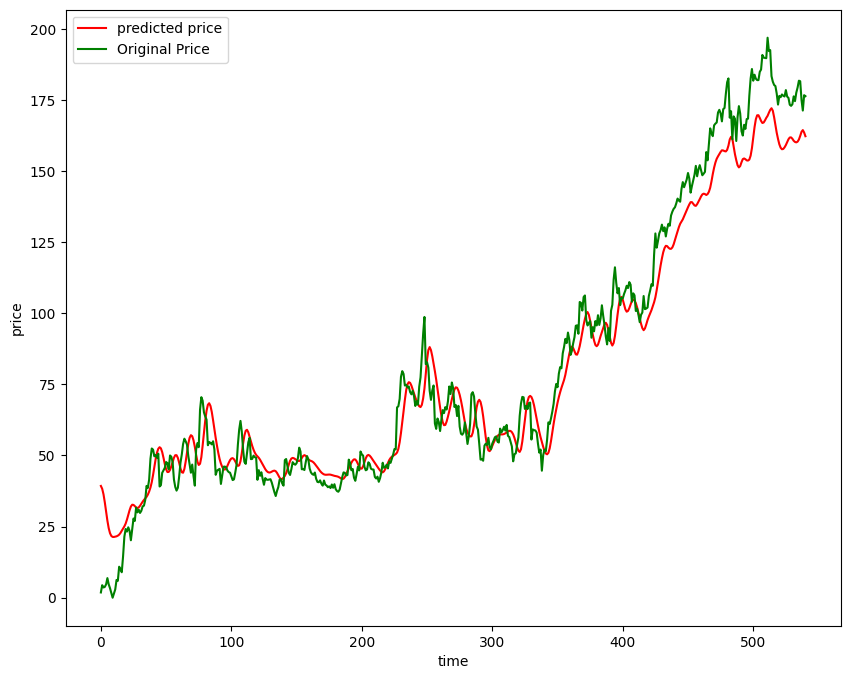

In [79]:
#plotting the predicted and actual values to see how good the model is
plt.figure(figsize=(10,8))
plt.plot(y_predicted,'r',label='predicted price')
plt.plot(y,'g',label = 'Original Price')
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

In [87]:
model.save('Stock_prediction_model.keras')